# Isolated Sign Language Recognition with STGCN

In this notebook, I will create Sign Language Recognition model using STGCN. To build an efficient training pipeline, I will use TFRecord Dataset from https://www.kaggle.com/datasets/lonnieqin/islr-12-time-steps-tfrecords created by notebook https://www.kaggle.com/code/lonnieqin/islr-create-tfrecord for training.
The ST-GCN model archetecture was adapated from https://github.com/kdkalvik/ST-GCN
It will take about 1 hour to finish runing this notebook using GPU.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## Configuration

In [ ]:
class CFG:
    data_path = "../input/asl-signs/"
    tf_record_path = "/kaggle/input/islr-12-time-steps-tfrecords/"
    sequence_length = 12
    rows_per_frame = 543
    is_training = True




## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import json
import time
import os
from kaggle_datasets import KaggleDatasets
np.random.seed(16)
tf.random.set_seed(16)

## Utilities

In [ ]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float16)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

## Load data

In [ ]:
train = pd.read_csv(f"{CFG.data_path}train.csv")
train.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


There are 21 participants. Each of them created about 3000 to 5000 training records.

In [ ]:
train.participant_id.nunique()

21

<AxesSubplot:>

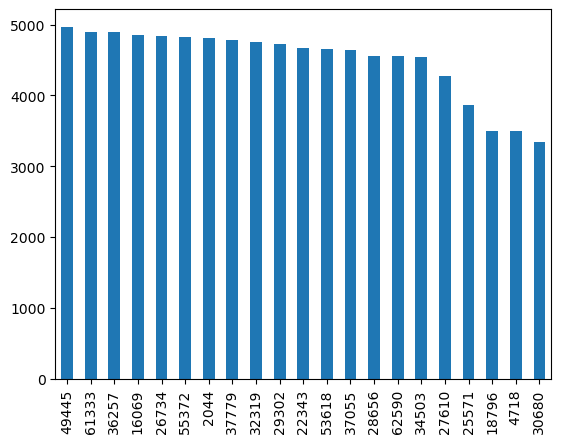

In [ ]:
train.participant_id.value_counts().plot(kind="bar")

There are 94477 training samples in total.

In [ ]:
len(train)

94477

There are 250 kinds of sign languages that we need to make prediction on.

In [ ]:
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = dict([(label_index[key], key) for key in label_index])
print(label_index)
train["label"] = train["sign"].map(lambda sign: label_index[sign])
train.head()

{'TV': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, 'fall': 74, 'farm': 75, 'fast': 76, 'feet': 77, 'find': 78, '

,path,participant_id,sequence_id,sign,label
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


## Create Tensorflow Dataset

In [ ]:
def decode_function(record_bytes):
    return tf.io.parse_single_example(
          # Data
          record_bytes,
          # Schema
          {
              "feature": tf.io.FixedLenFeature([12 * 543 * 3], dtype=tf.float32),
              "label": tf.io.FixedLenFeature([], dtype=tf.int64)
          }
      )
def preprocess(item):
    features = item["feature"]
#     features = tf.reshape(features, (1,CFG.sequence_length, 543,3))
    features=tf.reshape(features, (1,12, 543, 3))
#         "face"       : np.arange(0, 468),
#     "left_hand"  : np.arange(468, 489),
#     "pose"       : np.arange(489, 522),
#     "right_hand" : np.arange(522, 543),
    features=tf.transpose(features, perm=[3, 1, 2, 0])
    features1=features[:,-5:,468:489,:]
    features2=features[:,-5:,522:543,:]
    features=tf.concat([features1, features2],2)
    print(features.shape)
    return features, item["label"]
def make_dataset(file_paths, batch_size=128, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    options = tf.data.Options()
    if mode == "train":
        ds = ds.shuffle(1024)
        options.experimental_deterministic = False
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.with_options(options)
    ds = ds.cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
unique_ids = np.array(sorted(train.participant_id.unique()))
train_ds = make_dataset([f"{CFG.tf_record_path}{identifier}.tfrecords" for identifier in unique_ids[:-4]])
valid_ds = make_dataset([f"{CFG.tf_record_path}{identifier}.tfrecords" for identifier in unique_ids[-4:]], mode="valid")

(3, 5, 42, 1)
(3, 5, 42, 1)


In [ ]:
import numpy as np


def edge2mat(link, num_node):
    A = np.zeros((num_node, num_node))
    for i, j in link:
        A[j, i] = 1
    return A


def normalize_digraph(A):  # 除以每列的和
    Dl = np.sum(A, 0)
    h, w = A.shape
    Dn = np.zeros((w, w))
    for i in range(w):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i] ** (-1)
    AD = np.dot(A, Dn)
    return AD


def get_spatial_graph(num_node, self_link, inward, outward):
    I = edge2mat(self_link, num_node)
    In = normalize_digraph(edge2mat(inward, num_node))
    Out = normalize_digraph(edge2mat(outward, num_node))
    A = np.stack((I, In, Out))
    return A


![handlandmark](https://developers.google.com/static/mediapipe/images/solutions/hand-landmarks.png) create the node graph for hand landmarks

In [ ]:
num_node = 42
self_link = [(i, i) for i in range(num_node)]
inward_ori_index = [(1, 2), (2, 3), (3, 4), (4, 5), (1, 6), (6, 7), (7, 8),
                    (8, 9), (6, 10), (10, 11), (11, 12), (12, 13), (10, 14),
                    (14, 15), (15, 16), (16, 17), (14, 18), (18, 19), (19, 20),
                    (20, 21), (18, 1)]
inward_ori_index2=[(1+21, 2+21), (2+21, 3+21), (3+21, 4+21), (4+21, 5+21), (1+21, 6),
                   (6+21, 7+21), (7+21, 8+21), (8+21, 9+21), (6+21, 10+21),
                    (10+21, 11+21), (11+21, 12+21), (12+21, 13+21), (10+21, 14+21),
                    (14+21, 15+21), (15+21, 16+21), (16+21, 17+21), (14+21, 18+21), (18+21, 19+21), (19+21, 20+21),
                    (20+21, 21+21), (18+21, 1+21)]
inward_ori_index.extend(inward_ori_index2)
inward = [(i - 1, j - 1) for (i, j) in inward_ori_index]
outward = [(j, i) for (i, j) in inward]
neighbor = inward + outward

In [ ]:



class Graph:
    def __init__(self, labeling_mode='spatial'):
        self.A = self.get_adjacency_matrix(labeling_mode)
        self.num_node = num_node
        self.self_link = self_link
        self.inward = inward
        self.outward = outward
        self.neighbor = neighbor

    def get_adjacency_matrix(self, labeling_mode=None):
        if labeling_mode is None:
            return self.A
        if labeling_mode == 'spatial':
            A = get_spatial_graph(num_node, self_link, inward, outward)
        else:
            raise ValueError()
        return A


## Modeling

In [ ]:
REGULARIZER = tf.keras.regularizers.l2(l=0.001)
INITIALIZER = tf.keras.initializers.VarianceScaling(scale=2.,
                                                    mode="fan_out",
                                                    distribution="truncated_normal")
class SGCN(tf.keras.Model):
    def __init__(self, filters, kernel_size=3):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv2D(filters*kernel_size,
                                           kernel_size=1,
                                           padding='same',
                                           kernel_initializer=INITIALIZER,
                                           data_format='channels_first',
                                           kernel_regularizer=REGULARIZER)

    # N, C, T, V
    def call(self, x, A, training):
        x = self.conv(x)

        N = tf.shape(x)[0]
        C = tf.shape(x)[1]
        T = tf.shape(x)[2]
        V = tf.shape(x)[3]

        x = tf.reshape(x, [N, self.kernel_size, C//self.kernel_size, T, V])
        x = tf.einsum('nkctv,kvw->nctw', x, A)
        return x, A


"""Applies a spatial temporal graph convolution over an input graph sequence.
    Args:
        filters (int): Number of channels produced by the convolution
        kernel_size (tuple): Size of the temporal convolving kernel and graph convolving kernel
        stride (int, optional): Stride of the temporal convolution. Default: 1
        activation (activation function/name, optional): activation function to use
        residual (bool, optional): If ``True``, applies a residual mechanism. Default: ``True``
        downsample (bool, optional): If ``True``, applies a downsampling residual mechanism. Default: ``True``
                                     the value is used only when residual is ``True``
    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)` format
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Outpu graph sequence in :math:`(N, out_channels, T_{out}, V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V, V)` format
        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.
"""
class STGCN(tf.keras.Model):
    def __init__(self, filters, kernel_size=[9, 3], stride=1, activation='relu',
                 residual=True, downsample=False):
        super().__init__()
        self.sgcn = SGCN(filters, kernel_size=kernel_size[1])

        self.tgcn = tf.keras.Sequential()
        self.tgcn.add(tf.keras.layers.BatchNormalization(axis=1))
        self.tgcn.add(tf.keras.layers.Activation(activation))
        self.tgcn.add(tf.keras.layers.Conv2D(filters,
                                                kernel_size=[kernel_size[0], 1],
                                                strides=[stride, 1],
                                                padding='same',
                                                kernel_initializer=INITIALIZER,
                                                data_format='channels_first',
                                                kernel_regularizer=REGULARIZER))
        self.tgcn.add(tf.keras.layers.BatchNormalization(axis=1))

        self.act = tf.keras.layers.Activation(activation)

        if not residual:
            self.residual = lambda x, training=False: 0
        elif residual and stride == 1 and not downsample:
            self.residual = lambda x, training=False: x
        else:
            self.residual = tf.keras.Sequential()
            self.residual.add(tf.keras.layers.Conv2D(filters,
                                                        kernel_size=[1, 1],
                                                        strides=[stride, 1],
                                                        padding='same',
                                                        kernel_initializer=INITIALIZER,
                                                        data_format='channels_first',
                                                        kernel_regularizer=REGULARIZER))
            self.residual.add(tf.keras.layers.BatchNormalization(axis=1))

    def call(self, x, A, training=True):
        res = self.residual(x, training=training)
        x, A = self.sgcn(x, A, training=training)
        x = self.tgcn(x, training=training)
        x += res
        x = self.act(x)
        return x, A


"""Spatial temporal graph convolutional networks.
    Args:
        num_class (int): Number of classes for the classification task
    Shape:
        - Input: :math:`(N, in_channels, T_{in}, V_{in}, M_{in})`
        - Output: :math:`(N, num_class)` where
            :math:`N` is a batch size,
            :math:`T_{in}` is a length of input sequence,
            :math:`V_{in}` is the number of graph nodes,
            :math:`M_{in}` is the number of instance in a frame.
"""
class Model(tf.keras.Model):
    def __init__(self, num_classes=250):
        super().__init__()

        graph = Graph()
        self.A = tf.Variable(graph.A,
                             dtype=tf.float32,
                             trainable=False,
                             name='adjacency_matrix')

        self.data_bn = tf.keras.layers.BatchNormalization(axis=1)

        self.STGCN_layers = []
        self.STGCN_layers.append(STGCN(64, residual=False))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(128, stride=2, downsample=True))
        self.STGCN_layers.append(STGCN(128))
        self.STGCN_layers.append(STGCN(128))
        self.STGCN_layers.append(STGCN(256, stride=2, downsample=True))
        self.STGCN_layers.append(STGCN(256))
        self.STGCN_layers.append(STGCN(256))

        self.pool = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_first')

        self.logits = tf.keras.layers.Conv2D(num_classes,
                                             kernel_size=1,
                                             padding='same',
                                             kernel_initializer=INITIALIZER,
                                             data_format='channels_first',
                                             kernel_regularizer=REGULARIZER)

    def call(self, x, training):
        N = tf.shape(x)[0]
        C = tf.shape(x)[1]
        T = tf.shape(x)[2]
        V = tf.shape(x)[3]
        M = tf.shape(x)[4]

        x = tf.transpose(x, perm=[0, 4, 3, 1, 2])
        x = tf.reshape(x, [N * M, V * C, T])
        x = self.data_bn(x, training=training)
        x = tf.reshape(x, [N, M, V, C, T])
        x = tf.transpose(x, perm=[0, 1, 3, 4, 2])
        x = tf.reshape(x, [N * M, C, T, V])

        A = self.A
        for layer in self.STGCN_layers:
            x, A = layer(x, A, training=training)

        # N*M,C,T,V
        x = self.pool(x)
        x = tf.reshape(x, [N, M, -1, 1, 1])
        x = tf.reduce_mean(x, axis=1)
        x = self.logits(x)
        x = tf.reshape(x, [N, -1])
#         print(x.shape)
        return x


In [ ]:
model =  Model(num_classes=250)

In [ ]:
# Instantiate an optimizer to train the model.
optimizer = tf.keras.optimizers.Adam()

# Instantiate a loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric   = tf.keras.metrics.CategoricalAccuracy()

# tensorboard writer
train_writer = tf.summary.create_file_writer('logs/train/')
test_writer  = tf.summary.create_file_writer('logs/test/')


@tf.function
def train_step(step, x, y):
   '''
   input: x, y <- typically batches
   input: step <- batch step
   return: loss value
   '''

    # start the scope of gradient
   with tf.GradientTape() as tape:
        logits = model(x, training=True) # forward pass
        train_loss_value = loss_fn(y, logits) # compute loss

    # compute gradient
   grads = tape.gradient(train_loss_value, model.trainable_weights)

    # update weights
   optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # update metrics
   train_acc_metric.update_state(y, logits)

    # write training loss and accuracy to the tensorboard
   with train_writer.as_default():
        tf.summary.scalar('loss', train_loss_value, step=step)
        tf.summary.scalar(
            'accuracy', train_acc_metric.result(), step=step
        )
   return train_loss_value


@tf.function
def test_step(step, x, y):
   '''
   input: x, y <- typically batches
   input: step <- batch step
   return: loss value
   '''
    # forward pass, no backprop, inference mode
    val_logits = model(x, training=False)

    # Compute the loss value
    val_loss_value = loss_fn(y, val_logits)

    # Update val metrics
    val_acc_metric.update_state(y, val_logits)

    # write test loss and accuracy to the tensorboard
    with test_writer.as_default():
        tf.summary.scalar('val loss', val_loss_value, step=step)
        tf.summary.scalar(
            'val accuracy', val_acc_metric.result(), step=step
        )
    return val_loss_value


# custom training loop
for epoch in range(100):
    t = time.time()
    # batch training

    # Iterate over the batches of the train dataset.
    for train_batch_step, (x_batch_train, \
                           y_batch_train) in enumerate(train_dataset):
        train_batch_step = tf.convert_to_tensor(
                                train_batch_step, dtype=tf.int64
                           )
        train_loss_value = train_step(
                                train_batch_step,
                                x_batch_train, y_batch_train
                           )

    # evaluation on validation set
    # Run a validation loop at the end of each epoch.
    for test_batch_step, (x_batch_val, \
                          y_batch_val) in enumerate(val_dataset):
        test_batch_step = tf.convert_to_tensor(
                               test_batch_step, dtype=tf.int64
                          )
        val_loss_value = test_step(
                                test_batch_step, x_batch_val, y_batch_val
                          )


    template = '
        ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n
    '
    print(template.format(
        round((time.time() - t)/60, 2), epoch + 1,
        train_loss_value, float(train_acc_metric.result()),
        val_loss_value, float(val_acc_metric.result())
    ))

    # Reset metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

IndentationError: unexpected indent (2311950813.py, line 55)

In [ ]:
# def get_model():

#     model =  Model(num_classes=250)
#     model.build((128,3,5,42,1))
#     model.compile(
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[
#             "accuracy",
#         ]
#     )
#     return model

In [ ]:
# def conv1d_lstm_block(inputs, filters):
#     vector = tf.keras.layers.ConvLSTM1D(filters=32, kernel_size=8)(inputs)
#     for f in filters:
#         vector = tf.keras.layers.Conv1D(filters=f, kernel_size=8)(vector)
#         vector = tf.keras.layers.MaxPooling1D()(vector)
#     vector = tf.keras.layers.Dropout(0.3)(vector)
#     return vector

# def get_model():
#     inputs = tf.keras.Input((CFG.sequence_length, 543, 3), dtype=tf.float32)
#     face_inputs = inputs[:, :, 0:468, :]
#     left_hand_inputs = inputs[:, :, 468:489, :]
#     pose_inputs = inputs[:, :, 489:522, :]
#     right_hand_inputs = inputs[:, :,522:,:]
#     face_vector = conv1d_lstm_block(face_inputs, [32, 64])
#     left_hand_vector = conv1d_lstm_block(left_hand_inputs, [64])
#     right_hand_vector = conv1d_lstm_block(right_hand_inputs, [64])
#     pose_vector = conv1d_lstm_block(pose_inputs, [64])
#     vector = tf.keras.layers.Concatenate(axis=1)([face_vector, left_hand_vector, right_hand_vector, pose_vector])
#     vector = tf.keras.layers.Flatten()(vector)
#     output = tf.keras.layers.Dense(250, activation="softmax")(vector)
#     model = tf.keras.Model(inputs=inputs, outputs=output)
#     model.compile(
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[
#             "accuracy",
#         ]
#     )
#     return model

In [ ]:
model = get_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# https://towardsdatascience.com/model-sub-classing-and-custom-training-loop-from-scratch-in-tensorflow-2-cc1d4f10fb4e
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric   = tf.keras.metrics.CategoricalAccuracy()
# Instantiate a loss function
# loss_fn = tf.keras.losses.CategoricalCrossentropy()
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy()
for epoch in range(30): # <----- start for loop, step 1

  # <-------- start for loop, step 2
  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_ds):

    # <-------- start gradient tape scope, step 3
    # Open a GradientTape to record the operations run
    # during the forward pass, which enables auto-differentiation.
    with tf.GradientTape() as tape:

       # Run the forward pass of the layer.
       # The operations that the layer applies
       # to its inputs are going to be recorded
       # on the GradientTape.
       logits = model(x_batch_train, training=True)

       # Compute the loss value for this minibatch.
       loss_value = loss_fn(y_batch_train, logits)
       print(loss_value )

    # compute the gradient of weights w.r.t. loss  <-------- step 5
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss_value, model.trainable_weights)

    # update the weight based on gradient  <---------- step 6
    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y_batch_train, logits)
    print(train_acc_metric)

In [ ]:
if CFG.is_training:
    file_name = "model.h5"
#     callbacks = [
#         tf.keras.callbacks.ModelCheckpoint(
#             file_name,
#             save_best_only=True,
#             restore_best_weights=True,
#             monitor="val_accuracy",
#             mode="max"
#         ),
#         tf.keras.callbacks.EarlyStopping(
#             patience=5,
#             monitor="val_accuracy",
#             mode="max"
#         )
#     ]
    model.fit(train_ds, epochs=1, validation_data=valid_ds)
    model.save('/kaggle/input/islr-convlstm1d/model.h5',save_format='tf')
    model = tf.keras.models.load_model(file_name)
# else:
#     model = tf.keras.models.load_model("/kaggle/input/islr-convlstm1d/model.h5")
model.evaluate(valid_ds)

## Create Model for inference

In [ ]:
# def get_inference_model(model):
#     inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
#     vector = tf.image.resize(inputs, (CFG.sequence_length, 543))
#     vector = tf.where(tf.math.is_nan(vector), tf.zeros_like(vector), vector)
#     vector = tf.expand_dims(vector, axis=0)
#     vector = model(vector)
#     output = tf.keras.layers.Activation(activation="linear", name="outputs")(vector)
#     inference_model = tf.keras.Model(inputs=inputs, outputs=output)
#     inference_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
#     return inference_model

In [ ]:
# inference_model = get_inference_model(model)
# inference_model.summary()
# tf.keras.utils.plot_model(inference_model, show_shapes=True)

## Create submission file

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
# tflite_model = converter.convert()
# model_path = "model.tflite"
# # Save the model.
# with open(model_path, 'wb') as f:
#     f.write(tflite_model)
# !zip submission.zip $model_path

## Making Predictions

In [ ]:
# !pip install tflite-runtime

In [ ]:
# import tflite_runtime.interpreter as tflite
# interpreter = tflite.Interpreter(model_path)
# found_signatures = list(interpreter.get_signature_list().keys())
# prediction_fn = interpreter.get_signature_runner("serving_default")
# for i in tqdm(range(10000)):
#     frames = load_relevant_data_subset(f'/kaggle/input/asl-signs/{train.iloc[i].path}')
#     output = prediction_fn(inputs=frames)
#     if i < 100:
#         sign = np.argmax(output["outputs"])
#         print(f"Predicted label: {index_label[sign]}, Actual Label: {train.iloc[i].sign}")